In [1]:
import os
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import time
import itertools
import statsmodels.api as sm
import numpy.ma as ma
from scipy.stats.stats import pearsonr, normaltest
from scipy.spatial.distance import correlation
from sklearn.model_selection import train_test_split
os.getcwd()
os.chdir(r'C:\Users\Haneef Usmani\Desktop\STAT 303-2\Project')

In [2]:
flight = pd.read_csv('flights_clean.csv')

In [77]:
flight.columns

Index(['airline', 'day', 'day_of_week', 'departure_delay',
       'destination_airport', 'destination_latitude', 'destination_longitude',
       'distance', 'month', 'origin_airport', 'origin_latitude',
       'origin_longitude', 'scheduled_arrival', 'scheduled_departure',
       'scheduled_time', 'state_destination', 'state_origin', 'taxi_in',
       'taxi_out', 'day_of_year', 'origin_temperature',
       'destination_temperature'],
      dtype='object')

In [4]:
model_all = smf.ols(formula='departure_delay ~ airline + day + day_of_week + destination_airport + destination_latitude + destination_longitude + distance + month + origin_airport + origin_latitude + origin_longitude + scheduled_arrival + scheduled_departure + scheduled_time + state_destination + state_origin + taxi_in + taxi_out + day_of_year + origin_temperature + destination_temperature', data=flight).fit()
model_all.summary()

MemoryError: Unable to allocate 12.1 GiB for an array with shape (402, 4031919) and data type float64

In [3]:
# split flight into train and test
train, test = train_test_split(flight, test_size=0.2)

In [5]:
# drop all categorical variables from train
train_drop = train.drop(['airline', 'destination_airport', 'origin_airport', 'state_destination', 'state_origin'], axis=1)

In [6]:
X = train[['airline', 'day', 'day_of_week', 'destination_airport', 'destination_latitude', 'destination_longitude', 'distance', 'month', 'origin_airport', 'origin_latitude', 'origin_longitude', 'scheduled_arrival', 'scheduled_departure', 'scheduled_time', 'state_destination', 'state_origin', 'taxi_in', 'taxi_out', 'day_of_year', 'origin_temperature', 'destination_temperature']]
# take out all categorical variables
X = X.drop(['airline', 'destination_airport', 'origin_airport', 'state_destination', 'state_origin'], axis=1)

In [7]:
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = smf.ols('(departure_delay)~' + '+'.join(predictor_subset),data = train_drop).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [8]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [9]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [10]:
models_best = forward_selection()

Processed  16 models on 1 predictors in 8.12741208076477 seconds.
Processed  15 models on 2 predictors in 9.836007118225098 seconds.
Processed  14 models on 3 predictors in 10.54194450378418 seconds.
Processed  13 models on 4 predictors in 13.134437799453735 seconds.
Processed  12 models on 5 predictors in 16.103069305419922 seconds.
Processed  11 models on 6 predictors in 15.824368953704834 seconds.
Processed  10 models on 7 predictors in 15.907246589660645 seconds.
Processed  9 models on 8 predictors in 16.967482328414917 seconds.
Processed  8 models on 9 predictors in 16.88384771347046 seconds.
Processed  7 models on 10 predictors in 18.03978705406189 seconds.
Processed  6 models on 11 predictors in 15.867708444595337 seconds.
Processed  5 models on 12 predictors in 14.319014310836792 seconds.
Processed  4 models on 13 predictors in 13.070203065872192 seconds.
Processed  3 models on 14 predictors in 10.444658041000366 seconds.
Processed  2 models on 15 predictors in 7.89921641349792

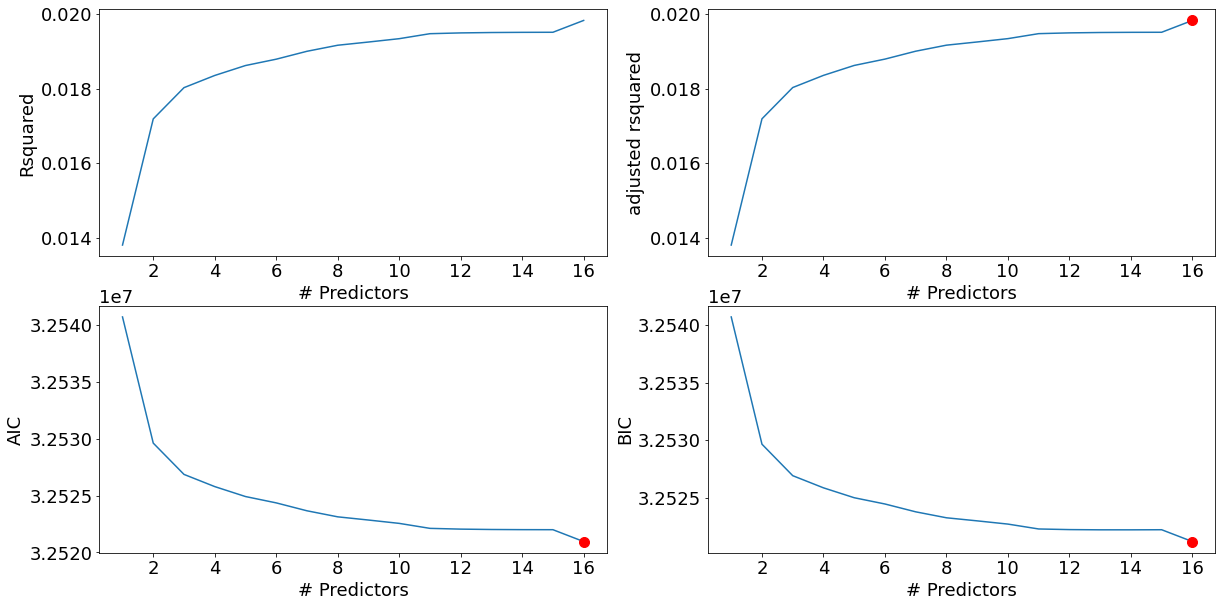

In [11]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

In [12]:
best_fwd_reg_model = models_best['model'][16]
best_fwd_reg_model.summary() # best model only with numerical variables

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        departure_delay   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     4079.
Date:                Sun, 05 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:41:55   Log-Likelihood:            -1.6260e+07
No. Observations:             3225535   AIC:                         3.252e+07
Df Residuals:                 3225518   BIC:                         3.252e+07
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 -29.5943      1.040    -28.455      0.000     -31.633     -27.556
scheduled_departure         0.0120   9.76e-05    123.404      0.000       0.012       0.012
taxi_out                    0.2226      0.002     93.304      0.000       0.218       0.227
scheduled_arrival           0.0045   9.25e-05     48.475      0.000       0.004       0.005
day_of_week                -0.3540      0.010    -33.769      0.000      -0.375      -0.333
taxi_in                     0.0895      0.004     24.093      0.000       0.082       0.097
scheduled_time              0.0235      0.003      9.164      0.000       0.018       0.028
destination_longitude       0.0290      0.002     15.802      0.000       0.025       0.033
day_of_year                -1.1073      0.034    -32.533      0.000      -1.174      -1.041
origin_longitude            0.0098      0.002      4.397      0.000       0.005       0.014
origin_latitude            -0.1267      0.005    -25.486      0.000      -0.136      -0.117
origin_temperature         -0.0446      0.002    -22.249      0.000      -0.049      -0.041
destination_latitude       -0.0421      0.005     -8.458      0.000      -0.052      -0.032
distance                   -0.0018      0.000     -5.794      0.000      -0.002      -0.001
destination_temperature    -0.0052      0.002     -2.601      0.009      -0.009      -0.001
month                      33.6293      1.037     32.433      0.000      31.597      35.662
day                         1.1011      0.034     32.334      0.000       1.034       1.168
==============================================================================
Omnibus:                  4329464.821   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1962321007.046
Skew:                           7.451   Prob(JB):                         0.00
Kurtosis:                     122.912   Cond. No.                     1.11e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
# print out all the predicotrs with their coefficients as a dataframe
pd.DataFrame(best_fwd_reg_model.params)
# rename the column names
pd.DataFrame(best_fwd_reg_model.params).rename(columns={0:'coefficients'})

,coefficients
Intercept,-29.594305
scheduled_departure,0.012039
taxi_out,0.222556
scheduled_arrival,0.004482
day_of_week,-0.353979
taxi_in,0.089497
scheduled_time,0.023468
destination_longitude,0.029021
day_of_year,-1.107288
origin_longitude,0.009818


In [19]:
# model equation
print('departuredelay =')
for i in range(len(X.columns)):
    if best_fwd_reg_model.params[i] != 0:
        print('{:+3f} * {}'.format(best_fwd_reg_model.params[i], X.columns[i]))

departuredelay =
-29.594305 * day
+0.012039 * day_of_week
+0.222556 * destination_latitude
+0.004482 * destination_longitude
-0.353979 * distance
+0.089497 * month
+0.023468 * origin_latitude
+0.029021 * origin_longitude
-1.107288 * scheduled_arrival
+0.009818 * scheduled_departure
-0.126722 * scheduled_time
-0.044608 * taxi_in
-0.042067 * taxi_out
-0.001823 * day_of_year
-0.005194 * origin_temperature
+33.629274 * destination_temperature


In [14]:
# RMSE
pred_price = (best_fwd_reg_model.predict(test))
np.sqrt(((pred_price - test.departure_delay)**2).mean())

37.35517169810643